# Theory where there is deep convection
This looks at the theory plot, but only considers days for which deep convection is occuring.
It is a repeat of `tau_sweep/aquaplanet/publish_figures/free_trop/single_kappa/_summer`

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-01-25 10:37:33,508 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [48]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag', 't_ref', 'ps', 'omega']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'aquaplanet/temp_tendency/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds_base = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds_base += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

Also get an equivalent dataset consisting of free troposphere rather than surface values: `ds_all_ft`.

In [49]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [141]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)
use_time_start = 360*2

lzb_thresh_deep = 12     # Need klzb to be lower than this so LZB is less than 560hPa (14) or 413hPa (12)
lzb_thresh_shallow = 14
convflag_thresh_deep = 1.8       # Need more than this to be considered deep convection
convflag_thresh_shallow = 0.8


ds = {'all': [], 'deep': [], 'shallow': [], 'none': []}  # need both all and summer day dataset
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds_base[i].sel(pfull=[np.inf, pressure_ft], method='nearest').sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds['all'] += [ds_use.load()]
        keep_deep = np.logical_and(ds_use.klzbs<lzb_thresh_deep, ds_use.convflag > convflag_thresh_deep)
        keep_shallow = np.logical_and(ds_use.klzbs<lzb_thresh_shallow, ds_use.convflag > convflag_thresh_shallow)
        keep_shallow = np.logical_and(keep_shallow, np.invert(keep_deep))       # make sure shallow does not include deep conv days
        keep_none = np.invert(np.logical_or(keep_deep, keep_shallow))           # no convection is all those that are not deep or shallow
        ds['deep'] += [ds_use.where(keep_deep).load()]
        ds['shallow'] += [ds_use.where(keep_shallow).load()]
        ds['none'] += [ds_use.where(keep_none).load()]
        pbar.update(1)
p_surface = float(ds['all'][0].pfull[0]) * 100
pressure_ft_actual = float(ds['all'][0].pfull[-1]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 2/2 [00:23<00:00, 11.58s/it]


In [142]:
# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

lat_use = np.where((np.abs(ds['all'][0].lat) <= lat_max) & (np.abs(ds['all'][0].lat) >= lat_min))[0]
lat_weights = np.cos(np.deg2rad(ds['all'][0].lat))     # latitude area weighting is just the cosine
lat_weights_use = lat_weights[lat_use]

In [143]:
# Get values averaged around a surface temperature percentile, rather than exactly on it.
get_all_lat_data = False

quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
n_lat = ds['all'][0].lat.shape[0]
n_pressure = ds['all'][0].pfull.shape[0]

# For averages, need both summer and all average
temp_mean = np.zeros((n_exp, n_pressure, n_lat))
mse_mean = np.zeros((n_exp, n_pressure, n_lat))
mse_ft_ref_mean = np.zeros((n_exp, n_lat))
# In free troposphere, this is saturated MSE.

# Note the quant3_type doesn't make much difference and only really makes a difference in the tropics
# where the equivalence of the temperature and moist static energy percentiles is not as valid.
quant3_method = 'temp'            # Take percentile to be temperature percentile      (this is legacy, what I was doing previously)
# quant3_method = 'mse'             # Take percentile to be of near-surface mse (think this is correct version of theory)
# All quantiles are over all days
temp_quant3 = {key: np.zeros((n_exp, n_pressure, n_lat, n_quant)) for key in ds}
mse_quant3 = {key: np.zeros((n_exp, n_pressure+1, n_lat, n_quant)) for key in ds}   # one for each pressure, and another for ref mse
mse_quant3_ft_ref = {key: np.zeros((n_exp, n_lat, n_quant)) for key in ds} 
omega_quant3 = {key: np.zeros((n_exp, n_lat, n_quant)) for key in ds}   # one for each pressure, and another for ref mse

# sphum_quant3 = {key: np.zeros((n_exp, n_lat, n_quant)) for key in ds}        # specific humidity as a function of quant3_type quantile
n_quant_days = {key: np.zeros((n_exp, n_lat, n_quant), dtype=int) for key in ds}        # record how many days at each quantile are convecting
with tqdm(total=n_exp*n_quant*(n_lat if get_all_lat_data else len(lat_use)) , position=0, leave=True) as pbar:
    for i in range(n_exp):
        mse = moist_static_energy(ds['all'][i].temp[0], ds['all'][i].sphum[0], ds['all'][i].height[0])
        mse_ft = moist_static_energy(ds['all'][i].temp[-1], sphum_sat(ds['all'][i].temp[-1], pressure_ft_actual), ds['all'][i].height[-1])
        mse_ft_ref = moist_static_energy(ds['all'][i].t_ref[-1], sphum_sat(ds['all'][i].t_ref[-1], pressure_ft_actual), ds['all'][i].height[-1])
        mse_mean[i, 0] = mse.mean(dim='lon_time')
        mse_mean[i, 1] = mse_ft.mean(dim='lon_time')
        mse_ft_ref_mean[i] = mse_ft_ref.mean(dim='lon_time')
        temp_mean[i] = ds['all'][i].temp.mean(dim='lon_time')
        for k in range(n_lat):
            if not get_all_lat_data:
                if k not in lat_use:
                    # Skip latitudes if don't need them all
                    continue
            mse_use = [mse[k], mse_ft[k], mse_ft_ref[k]]
            for j, quant in enumerate(quant_plot):
                if quant3_method == 'temp':
                    use_ind = get_quant_ind(ds['all'][i].temp[0, k], quant, 0.5, 0.5)
                elif quant3_method == 'mse':
                    use_ind = get_quant_ind(mse[k], quant, 0.5, 0.5)
                else:
                    raise ValueError('quant3_type not valid')
                for key in ds:
                    temp_quant3[key][i, :, k, j] = ds[key][i].temp[:, k, use_ind].mean(dim='lon_time', skipna=True)
                    keep_deep = ds[key][i].temp[0, k]>0
                    mse_quant3[key][i, 0, k, j] = mse_use[0].where(keep_deep)[use_ind].mean(dim='lon_time', skipna=True)    
                    mse_quant3[key][i, 1, k, j] = mse_use[1].where(keep_deep)[use_ind].mean(dim='lon_time', skipna=True)
                    mse_quant3_ft_ref[key][i, k, j] = mse_use[2].where(keep_deep)[use_ind].mean(dim='lon_time', skipna=True)
                    # sphum_quant3[key][i, k, j] = ds[key][i].sphum[0, k, use_ind].mean(dim='lon_time', skipna=True)
                    omega_quant3[key][i, k, j] = ds[key][i].omega[-1, k].where(keep_deep)[use_ind].mean(dim='lon_time', skipna=True)
                    n_quant_days[key][i, k, j] = np.sum(keep_deep[use_ind])
                pbar.update(1)

100%|██████████| 2772/2772 [01:36<00:00, 28.86it/s]


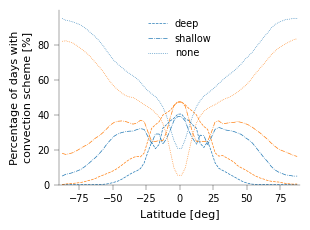

In [144]:
conv_linestyles = {'all': '-', 'deep': '--', 'shallow': '-.', 'none': ':'}

save_conv_percentage_fig = False
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
for i in range(n_exp):
    for key in ['deep', 'shallow', 'none']:
        ax.plot(ds[key][i].lat, 100*(ds[key][i].temp[0]>0).sum(dim='lon_time')/ds[key][i].dims['lon_time'], 
                   label=key if i == 0 else None, linestyle=conv_linestyles[key], color=default_colors[i])
ax.legend()
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('Percentage of days with\nconvection scheme [%]')
ax.set_xlim(-90, 90)
ax.set_ylim(0, ax.get_ylim()[1])
plt.tight_layout()

if save_fig or save_conv_percentage_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/conv_percentage.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## $\lambda$ Decompostion
### Combine latitudes
Here, I break down the $\lambda=1$ approximation into three different factors. $\lambda_1$ represents CQE on the $x$ percentile day. $\lambda_2$ represents the weak temperature gradient approximation and $\lambda_3$ represents CQE on the mean day.

Note the black line below differs from actual $\lambda$ because here I am plotting it as a function of near-surface temperature percentile, whereas for lambda plot in `surface/single_kappa` notebook, I plot it as a function of near-surface MSE percentile. I.e. the x-axis are different.

The different linestyles indicate the convection scheme used. `--` for deep, `-.` for shallow and `:` for none.

In [145]:
lambda_1 = {key: (mse_quant3[key][1] - mse_quant3[key][0])[0] / (mse_quant3[key][1]-mse_quant3[key][0])[1] for key in ds}
lambda_1_ref = {key: (mse_quant3[key][1] - mse_quant3[key][0])[0] / (mse_quant3_ft_ref[key][1]-mse_quant3_ft_ref[key][0]) for key in ds}
lambda_2 = {key: (mse_quant3[key][1]-mse_quant3[key][0])[1] / np.expand_dims(mse_mean[1]-mse_mean[0], axis=-1)[1] for key in ds} 
lambda_2_ref = {key: (mse_quant3_ft_ref[key][1]-mse_quant3_ft_ref[key][0]) / np.expand_dims(mse_mean[1]-mse_mean[0], axis=-1)[1] for key in ds} 
lambda_3 = {key: (mse_mean[1]-mse_mean[0])[0] / (mse_mean[1]-mse_mean[0])[1] for key in ds}
lambda_full = {key: (mse_quant3[key][1]-mse_quant3[key][0])[0] / np.expand_dims(mse_mean[1]-mse_mean[0], axis=-1)[0] for key in ds}
labels = ['$\lambda(x) = \lambda_1(x) \lambda_2(x) / \overline{\lambda_1}$',
          '$\lambda_1(x)$',
          '$\lambda_2(x)$',
          '$\overline{\lambda_1}$']

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_53411/4115518046.py:1: RuntimeWarning: invalid value encountered in true_divide
  lambda_1 = {key: (mse_quant3[key][1] - mse_quant3[key][0])[0] / (mse_quant3[key][1]-mse_quant3[key][0])[1] for key in ds}
/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_53411/4115518046.py:2: RuntimeWarning: invalid value encountered in true_divide
  lambda_1_ref = {key: (mse_quant3[key][1] - mse_quant3[key][0])[0] / (mse_quant3_ft_ref[key][1]-mse_quant3_ft_ref[key][0]) for key in ds}


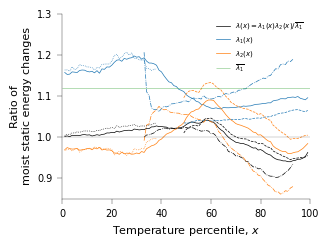

In [146]:
# Using lambda relative to mean overall then mean summer day
percentile_label = 'Temperature percentile, $x$' if quant3_method == 'temp' else 'MSE percentile, $x$'
lambda_days_thresh = 350        # only plot lambda for a quantile if there are more than this number of days

save_lambda_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for key in ds:
    for i, var in enumerate([lambda_full[key], lambda_1[key], lambda_2[key]]):
        use_color = 'k' if i == 0 else default_colors[i-1]
        n_quant_days_use = np.average(n_quant_days[key][:, lat_use], axis=1, weights=lat_weights_use)
        n_quant_days_use = np.min(n_quant_days_use, axis=0)
        ax.plot(quant_plot[n_quant_days_use>lambda_days_thresh], 
                np.average(var[lat_use], axis=0, weights=lat_weights_use)[n_quant_days_use>lambda_days_thresh],
                color=use_color, label=labels[i] if key == 'all' else None, linestyle=conv_linestyles[key])
# ax.plot(quant_plot, np.average(lambda_1, axis=0, weights=lat_weights), color=default_colors[0], label=labels[1])
# ax.plot(quant_plot, np.average(lambda_2, axis=0, weights=lat_weights), color=default_colors[1])
ax.hlines(np.average(lambda_3[key][lat_use], axis=0, weights=lat_weights_use), 0, 100, color=default_colors[2], alpha=0.5, label=labels[3])
ax.hlines(1, 0, 100, color='k', lw=ax_linewidth, alpha=0.5)
ax.legend(fontsize=5)
ax.set_xlim(0, 100)
ax.set_ylim(0.85, 1.3)
ax.set_xlabel(percentile_label)
ax.set_ylabel('Ratio of\nmoist static energy changes')
if save_fig or save_lambda_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_{region.lower()}_all.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### $\lambda_1$ when using convective reference $T_{FT}$
If I use the convective reference $T_{FT}$ rather than the simulated $T_{FT}$, we expect $\lambda_1$ to be basically un-changed and not equal to 1 for no and shallow convection. We expect it to be unchanged because convection has acted fast enough to force the temperature profile to be equal to the reference profile. We expect it to not equal 1 because the reference profile is not a moist adiabat.

For deep convection. we expect there to be significant differences. For deep convection, the Isca convective reference profile is the moist adiabat, so we would expect $\lambda_1(x) = 1$ when using it. Convection does not happen immediately though, so the actual simulated profile has not yet reached the convective reference profile. Thus the simulated $\lambda_1(x) \neq 1$.

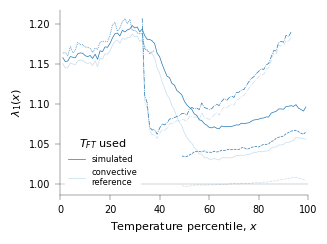

In [147]:
save_lambda1_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
labels_lambda1 = ['simulated','convective\nreference']
for key in ds:
    for i, var in enumerate([lambda_1[key], lambda_1_ref[key]]):
        use_color = default_colors[0]
        n_quant_days_use = np.average(n_quant_days[key][:, lat_use], axis=1, weights=lat_weights_use)
        n_quant_days_use = np.min(n_quant_days_use, axis=0)
        ax.plot(quant_plot[n_quant_days_use>lambda_days_thresh], 
                np.average(var[lat_use], axis=0, weights=lat_weights_use)[n_quant_days_use>lambda_days_thresh],
                color=use_color, label=labels_lambda1[i] if key == 'all' else None, linestyle=conv_linestyles[key], alpha=0.25 if i==1 else 1)
ax.hlines(1, 0, 100, color='k', lw=ax_linewidth, alpha=0.5)
ax.set_ylabel(labels[1])
ax.legend(title='$T_{FT}$ used', fontsize=6, frameon=True, framealpha=1, edgecolor='white')
ax.set_xlabel(percentile_label)
# ax.set_ylim(1, ax.get_ylim()[1])
ax.set_xlim(0, 100)

if save_fig or save_lambda1_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda1_{region.lower()}_all.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

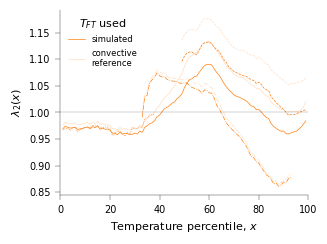

In [148]:
save_lambda2_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for key in ds:
    for i, var in enumerate([lambda_2[key], lambda_2_ref[key]]):
        use_color = default_colors[1]
        n_quant_days_use = np.average(n_quant_days[key][:, lat_use], axis=1, weights=lat_weights_use)
        n_quant_days_use = np.min(n_quant_days_use, axis=0)
        ax.plot(quant_plot[n_quant_days_use>lambda_days_thresh], 
                np.average(var[lat_use], axis=0, weights=lat_weights_use)[n_quant_days_use>lambda_days_thresh],
                color=use_color, label=labels_lambda1[i] if key == 'all' else None, linestyle=conv_linestyles[key], alpha=0.25 if i==1 else 1)
ax.hlines(1, 0, 100, color='k', lw=ax_linewidth, alpha=0.5)
ax.set_ylabel(labels[2])
ax.legend(title='$T_{FT}$ used', fontsize=6, frameon=True, framealpha=1, edgecolor='white')
ax.set_xlabel(percentile_label)
# ax.set_ylim(1, ax.get_ylim()[1])
ax.set_xlim(0, 100)

if save_fig or save_lambda2_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda2_{region.lower()}_all.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

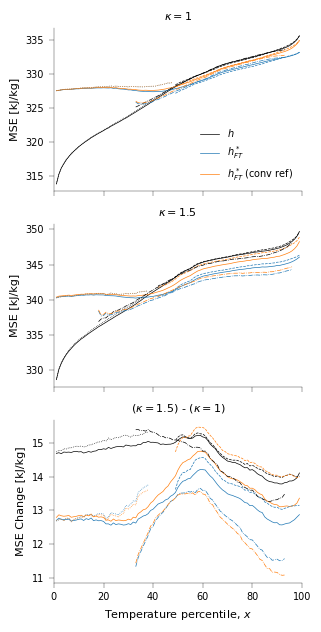

In [149]:
save_mse_change_fig = False
fig, ax = plt.subplots(3,1, figsize=(width['one_col'], 3*width['one_col']/ar), sharex=True)
for key in ds:
    n_quant_days_use = np.average(n_quant_days[key][:, lat_use], axis=1, weights=lat_weights_use)
    for i in range(n_exp):
        ax[i].plot(quant_plot[n_quant_days_use[i]>lambda_days_thresh], 
                   np.average(mse_quant3[key][i, 0, lat_use], axis=0, weights=lat_weights_use)[n_quant_days_use[i]>lambda_days_thresh],
                   color='k', linestyle=conv_linestyles[key], label='$h$' if key == 'all' else None)
        ax[i].plot(quant_plot[n_quant_days_use[i]>lambda_days_thresh], 
                   np.average(mse_quant3[key][i, 1, lat_use], axis=0, weights=lat_weights_use)[n_quant_days_use[i]>lambda_days_thresh],
                   color=default_colors[0], linestyle=conv_linestyles[key], label='$h_{FT}^*$' if key == 'all' else None)
        ax[i].plot(quant_plot[n_quant_days_use[i]>lambda_days_thresh], 
                   np.average(mse_quant3_ft_ref[key][i, lat_use], axis=0, weights=lat_weights_use)[n_quant_days_use[i]>lambda_days_thresh],
                   color=default_colors[1], linestyle=conv_linestyles[key], label='$h_{FT}^*$ (conv ref)' if key == 'all' else None)
    n_quant_days_use = np.min(n_quant_days_use, axis=0)
    ax[-1].plot(quant_plot[n_quant_days_use>lambda_days_thresh], np.average(mse_quant3[key][1, 0, lat_use]-mse_quant3['all'][0, 0, lat_use], axis=0, weights=lat_weights_use)[n_quant_days_use>lambda_days_thresh],
               color='k', linestyle=conv_linestyles[key])
    ax[-1].plot(quant_plot[n_quant_days_use>lambda_days_thresh], np.average(mse_quant3[key][1, 1, lat_use]-mse_quant3['all'][0, 1, lat_use], axis=0, weights=lat_weights_use)[n_quant_days_use>lambda_days_thresh],
               color=default_colors[0], linestyle=conv_linestyles[key])
    ax[-1].plot(quant_plot[n_quant_days_use>lambda_days_thresh], np.average(mse_quant3_ft_ref[key][1, lat_use]-mse_quant3_ft_ref['all'][0, lat_use], axis=0, weights=lat_weights_use)[n_quant_days_use>lambda_days_thresh],
               color=default_colors[1], linestyle=conv_linestyles[key])
ax[0].legend()
ax[-1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('MSE [kJ/kg]')
ax[1].set_ylabel('MSE [kJ/kg]')
ax[2].set_ylabel('MSE Change [kJ/kg]')
ax[0].set_title(f'$\kappa = {tau_lw[0]}$')
ax[1].set_title(f'$\kappa = {tau_lw[1]}$')
ax[2].set_title(f'$(\kappa = {tau_lw[1]})$ - $(\kappa = {tau_lw[0]})$')
if save_fig or save_mse_change_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_change_{region.lower()}_all.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)
# plt.plot(np.average(mse_quant3['all'][1, 0, lat_use], axis=0, weights=lat_weights_use))
# plt.plot(np.average(mse_quant3['all'][1, 1, lat_use], axis=0, weights=lat_weights_use))
# plt.plot(np.average(mse_quant3_ft_ref['all'][1, lat_use], axis=0, weights=lat_weights_use))
# plt.plot(np.average(mse_quant3['all'][0, 0, lat_use]-mse_quant3_ft_ref['all'][0, lat_use], axis=0, weights=lat_weights_use))
# plt.plot(np.average(mse_quant3_diff['all'][1, lat_use], axis=0, weights=lat_weights_use))

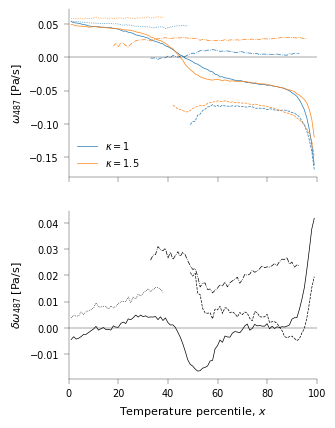

In [150]:
save_omega_change_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for key in ds:
    n_quant_days_use = np.average(n_quant_days[key][:, lat_use], axis=1, weights=lat_weights_use)
    for i in range(n_exp):
        ax[0].plot(quant_plot[n_quant_days_use[i]>lambda_days_thresh], 
                   np.average(omega_quant3[key][i, lat_use], axis=0, weights=lat_weights_use)[n_quant_days_use[i]>lambda_days_thresh],
                   color=default_colors[i], linestyle=conv_linestyles[key], label=f'$\kappa={tau_lw[i]}$' if key == 'all' else None)
    n_quant_days_use = np.min(n_quant_days_use, axis=0)
    ax[-1].plot(quant_plot[n_quant_days_use>lambda_days_thresh],
                np.average(omega_quant3[key][1, lat_use]-omega_quant3[key][0, lat_use], 
                           axis=0, weights=lat_weights_use)[n_quant_days_use>lambda_days_thresh],
                color='k', linestyle=conv_linestyles[key])
ax[0].hlines(0, -100, 100, lw=ax_linewidth, color='k')
ax[1].hlines(0, -100, 100, lw=ax_linewidth, color='k')
ax[0].legend()
ax[-1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel(f"$\omega_{'{'+str(round(pressure_ft_actual/100))+'}'}$ [Pa/s]")
ax[1].set_ylabel(f"$\delta \omega_{'{'+str(round(pressure_ft_actual/100))+'}'}$ [Pa/s]")
if save_fig or save_mse_change_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_change_{region.lower()}_all.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)
    
if save_fig or save_omega_change_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/omega_change_{region.lower()}_all.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)